Back to the [README](./README.md)

Back to the [analysis notebook](./analysis.ipynb)

--------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

from setup import df, Col, Palette, quick_regression
from setup import df_low as df_low_from_setup

--------------------

## 1. Is there a relation between the age and insurance charges?

To answer this question, let's look at a few plots.  The first shall be a
naive one without grouping or categorizing, while the others look into more
detail regarding our categories.

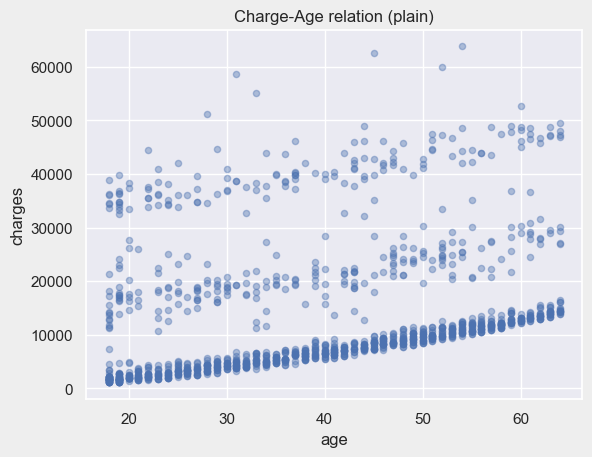

In [2]:
# Plain Plot
df.plot.scatter(x=Col.age, y=Col.charges, title='Charge-Age relation (plain)', alpha=.4)
plt.show()

Not only does this plot confirm the hypothesis that an advanced age comes with higher
insurance charges, but also does it reveal that there seem to be three levels or
offsets those charges are calculated around.

The most commonly used computation, judging by the density of the data points, _appears_
to have a linear correlation with the age with a small offset. (We will soon see
that this is actually not the case.)
A second and a third level appear to use the same linear formula but with different
offsets.  This already prompts the next hypothesis that we are going to check within
this notebook:

> **Question 20:**<br/>
> Are the elevated charge levels related to one or more properties or attributes of
> the dataset?  If so, which are those attributes?

For now, let us continue to try and discover whether there are categorical influences
on the data.  For that, we create four plots, one for each of the categories
`sex`, `children`, `smoker` and `region`.

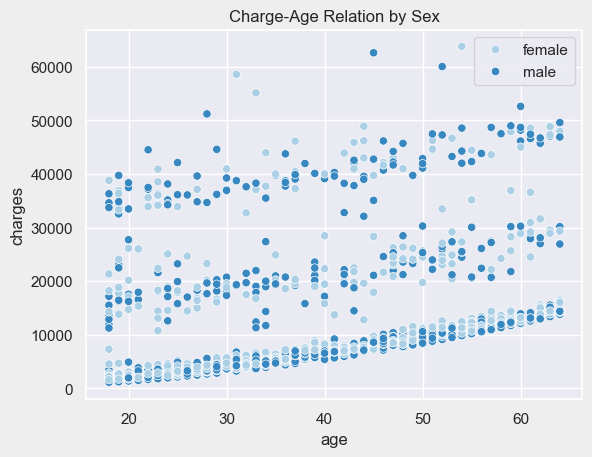

In [3]:
# Plot categorized by sex
sns.scatterplot(data=df, x=Col.age, y=Col.charges, hue=Col.sex, palette=Palette.bl)
plt.title('Charge-Age Relation by Sex')
plt.legend()
plt.show()

As a reminder to the previous graphic, sex `1` corresponds to female while sex `2` corresponds
to male, respectively.
Now, having a closer look at the plot than we had in our first glance in the [analysis notebook](./analysis.ipynb), we see no further indication that the sex had a deeper impact on the charges in general.
But just to be extra careful with this statement, let us check the average charge per age and sex together:

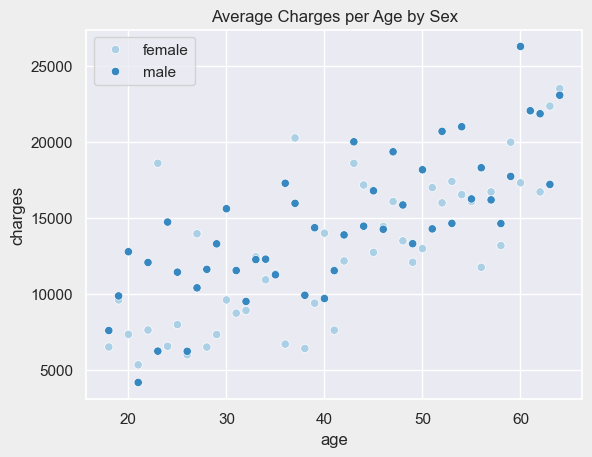

In [4]:
sns.scatterplot(data=df.groupby([Col.sex, Col.age]).mean(Col.charges), x=Col.age, y=Col.charges, hue=Col.sex, palette=Palette.bl)
plt.title('Average Charges per Age by Sex')
plt.legend()
plt.show()

The graph only indicates that males do seem to cause higher charges on average than females,
but we cannot draw any actual quantitative conclusion out of this.  That is to say that the
age itself seems to have a greater impact on the charges than the sex, which somewhat
plays into hypothesis number 2 (see the [next notebook](./sex-charge-relation.ipynb)).

Moving on with the children.  For this part, we use our understanding that we got from
our initial glance in the [analysis notebook](./analysis.ipynb) to introduce new categories:
`no children`, `less than 3 children` and `3 or more children`.  The motivation to do so stems from the
observation that there is a unique behavior for the former case, and that the latter unifies
cases that do not contribute significant insight when treated individually.

In [5]:
# Introduce a new category to handle those cases:
class Children(int):
    """Extends integers used to count the number of children with categorical capabilities."""
    categories = ['no children', 'less than 3 children', '3 or more children']

    def category(self) -> str:
        match self:
            case 0:
                return Children.categories[0]
            case 1 | 2:
                return Children.categories[1]
            case _:
                return Children.categories[2]

# Create the new column for this categorization
df[Col.children_cat] = df.children.apply(Children.category)

# Check that everything works as intended:
df.head()

,age,sex,bmi,children,smoker,region,charges,children category
0,19,female,27.900,0,True,southwest,16884.92400,no children
1,18,male,33.770,1,False,southeast,1725.55230,less than 3 children
2,28,male,33.000,3,False,southeast,4449.46200,3 or more children
3,33,male,22.705,0,False,northwest,21984.47061,no children
4,32,male,28.880,0,False,northwest,3866.85520,no children


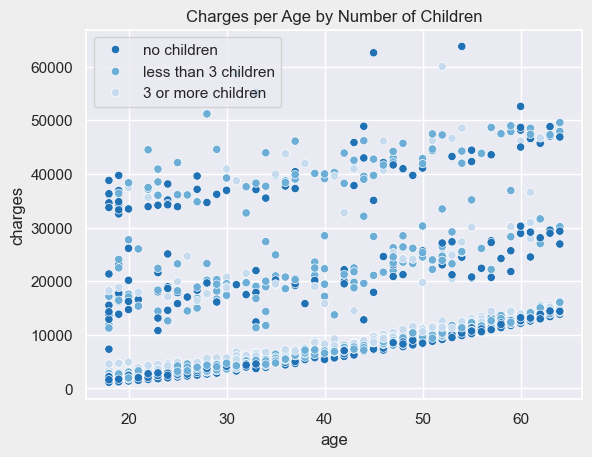

In [6]:
# Plot categorized by children
sns.scatterplot(data=df, x=Col.age, y=Col.charges, hue=Col.children_cat, palette=Palette.bl + '_r')
plt.title('Charges per Age by Number of Children')
plt.legend()
plt.show()

Again, we don't get any deep insight into the influence of having children into the
age-related charge computation.  So let us move on.

Next is the influence of smoking.  And based on our initial glance, we will find something
interesting here:

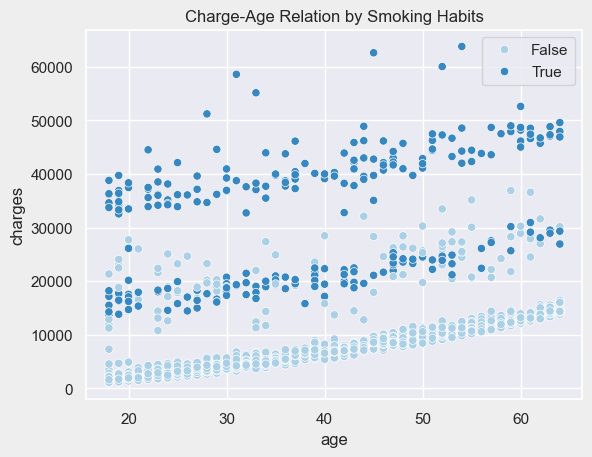

In [7]:
# Plot categorized by smoker
sns.scatterplot(data=df, x=Col.age, y=Col.charges, hue=Col.smoker, palette=Palette.bl)
plt.title('Charge-Age Relation by Smoking Habits')
plt.legend()
plt.show()

At this point, we can say with absolute certainty that the lowest of the three charge levels
is reserved for non-smokers while the highest one is reserved for smokers exclusively.
This ties into questions [5](./smoker-charge-relation.ipynb) and 20.

For the intermediate level, there are representatives of both groups, meaning that there is
another decisive factor for assigning the offset for the charges.  We do not care for this
particular case right now; question 20 is meant to look closer into this issue.

Finally, we look at the regional influence on the charges.  We know already from our initial
glimpse that there is nothing particularly interesting to be found when looking at all four
regions individually, so let us introduce two new categories to see if we can spot
something when looking on `east`ern and `west`ern regions as well as on `north`ern and
`south`ern ones:

In [8]:
# Import Region category from setup
from setup import Region

# Create two new columns for the new categories:
df['ns'] = df.region.map(lambda r: 'north' if r.is_north else 'south')
df['ew'] = df.region.map(lambda r: 'east' if r.is_east else 'west')

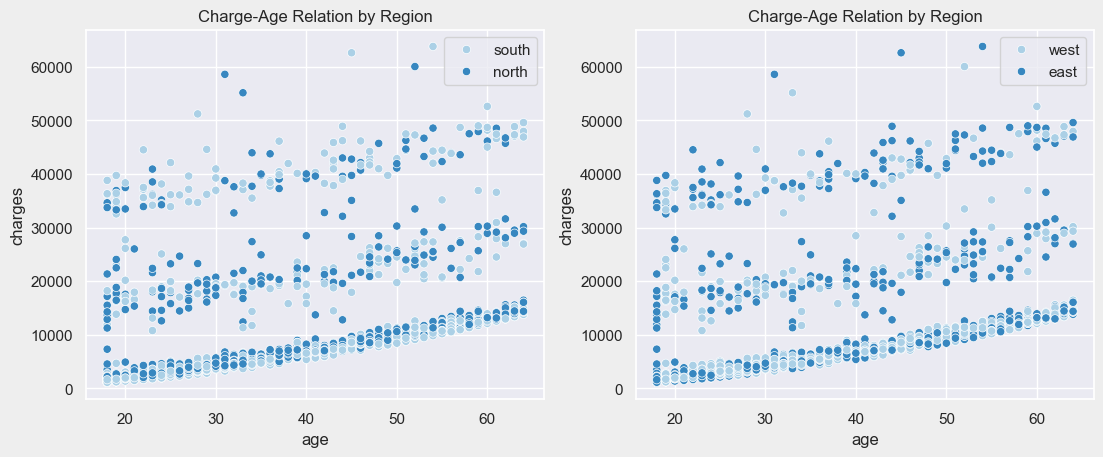

In [9]:
# Plot categorized by regions
plt.figure(figsize=(13, 4.8))
plt.subplot(121)
sns.scatterplot(data=df, x=Col.age, y=Col.charges, hue='ns', palette=Palette.bl)
plt.title('Charge-Age Relation by Region')
plt.legend()
plt.subplot(122)
sns.scatterplot(data=df, x=Col.age, y=Col.charges, hue='ew', palette=Palette.bl)
plt.title('Charge-Age Relation by Region')
plt.legend()
plt.show()

We can see no indication that the region had any influence on the charges at all.  One might
spot small clusters, but in general there is nothing to justify further investigation into those
based on the previous graphic.  A look at the average charges per age and region, captured in
the following pivot table and displayed in the subsequent graph, also reveals no such correlation.

In [10]:
# Average Charges per Age and Region
pd.pivot_table(df[[Col.region, Col.age, Col.charges]], values=Col.charges, index=Col.region, columns=Col.age)

age,18,19,20,21,22,23,24,25,26,27,...,55,56,57,58,59,60,61,62,63,64
region,,,,,,,,,,,,,,,,,,,,,
northeast,7558.732497,NaN,7876.547375,4637.123900,2952.241964,20813.061506,17977.227959,8042.713873,8303.722420,9572.962407,...,16784.513842,13392.220736,15810.910384,12478.576450,21787.622242,15897.064952,19197.727433,24710.057935,17276.232210,14944.022862
northwest,NaN,9479.636524,11198.324579,5830.544660,7159.279914,9539.486970,4523.931489,5222.660443,3157.814357,10817.373858,...,14480.102075,19524.749967,16249.709514,17127.287079,15387.654710,22740.416334,18653.964817,19747.446692,16856.068542,20971.302894
southeast,6677.555986,35570.314200,10213.452252,4056.664759,20299.833288,9395.051429,10656.494520,15651.834784,5137.607600,17490.830689,...,17513.428731,16967.849133,22261.293035,13768.127590,19387.884108,24170.585983,30238.455784,17950.449238,19645.384050,26134.965188
southwest,NaN,7543.201624,10909.507504,4397.524000,7863.799833,9931.680254,9434.409881,10436.252143,7936.156857,8639.865333,...,15728.069440,11137.467429,11605.786500,11600.328167,18271.609738,25236.439732,21376.682097,13264.195600,25327.514667,27669.870200


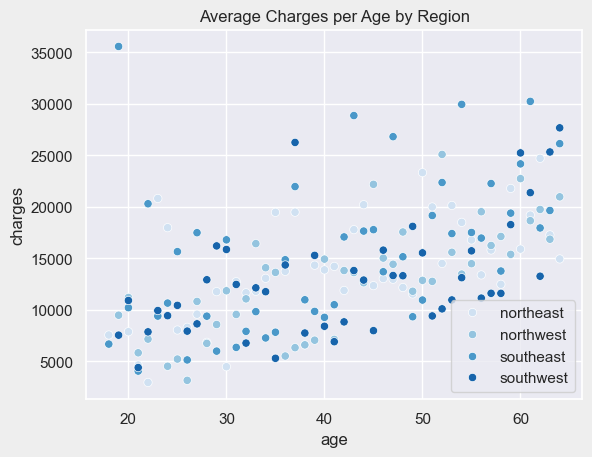

In [11]:
sns.scatterplot(data=df.groupby([Col.region, Col.age]).mean(Col.charges), x=Col.age, y=Col.charges, hue=Col.region, palette=Palette.bl)
plt.title('Average Charges per Age by Region')
plt.legend()
plt.show()

## Intermediate Summary

So far, we discovered that there *is* a correlation between the charges and the age,
but we have yet to find its nature.  Furthermore, we found that obviously smoking has
a great influence on the offset parameter, but there seem to be no further parameters
or categories affecting the curvature of the function describing this behavior.  And
we suspect there to be something else beside the smoking habits that determines said
offset.

For the rest of this notebook we will focus on finding an expression that describes
the curvature of the function that predicts the charges with respect to the age.
We will also try to estimate the three offsets, but we might refine them later as
we might identify additional factors as we go on investigating the dataset.

For now, let us return to our initial graphic:

![](./images/charge-age-relation-plain.png)

We assume that all three levels are based on the same function with the same
curvature, and differ only in an offset.  Thus, we will try to isolate the
lowest level in order to perform some regression on the data subset.

The way we will do this is as follows:  We may naively assume that the correlation
was linear,
$$
c_{i, r}(a) \stackrel{?}{=} m \cdot a + n_{i, r} 
$$
where $c_{i, r}$ is the charges, $i \in \{1, 2, 3\}$ enumerates the three functions, $m$
is the slope we assume to find, $a$ is the age, $n_{i, r}$ the offset for the
individual functions, and $r$ indicates some randomness going on independent of
$a$ (thus, we put it into the $n_{i, r}$ part).

If (for the lowest level, $i = 1$) we had $n_{1, r} = 0$, then we could divide
our charges by the ages to find $m$ being a constant over all ages.  Let us try
that out and see what we get:

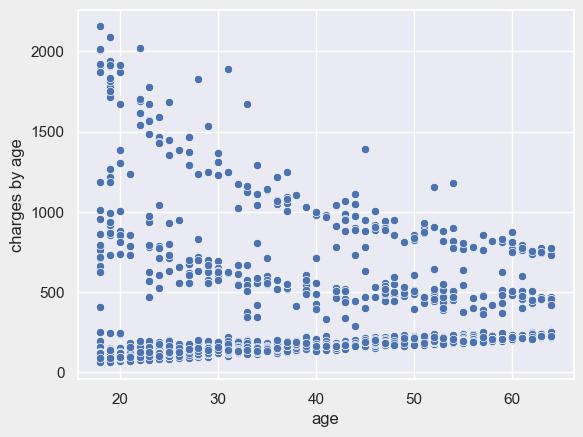

In [12]:
# Create a new column for the new values to plot on the y axis
df['charges by age'] = df.charges / df.age

# Plot the new values
sns.scatterplot(data=df, x=Col.age, y='charges by age')
plt.show()

Not bad, but our assumption is off.  Yet we do get a good grip to introduce a filter
to isolate the lower level from the others:  We see that there is a a limit at around
roughly 250 that separates the lower levels from the others.  (We choose 260, however,
because we would otherwise exclude one or two points that seem to belong to our level.)

Let us apply this limit to filter the data we are going to use moving forward.  And
to convince ourselves of the validity of this choice, let us look at the unfiltered and
the filtered values side-by-side:

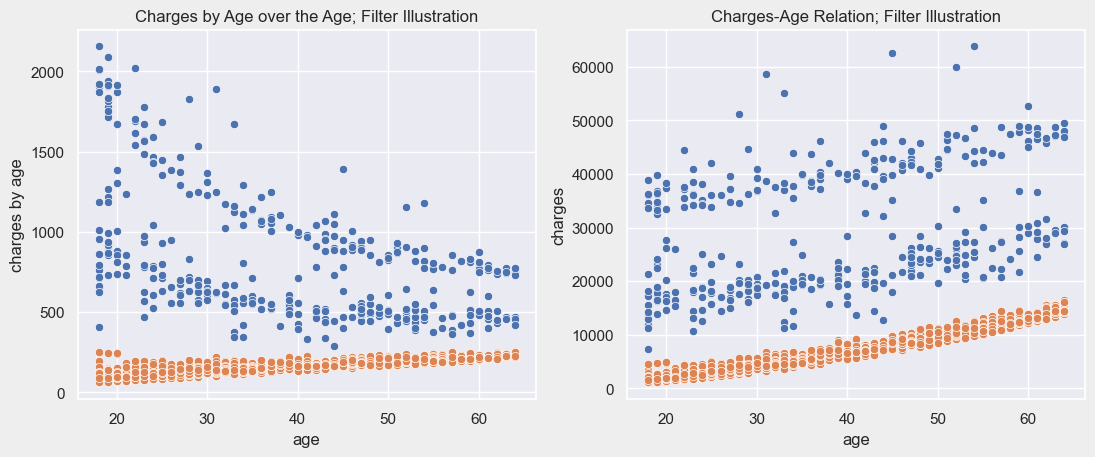

In [13]:
df_low = pd.DataFrame(df[df['charges by age'] < 260])         # df for $i = 1$
plt.figure(figsize=(13, 4.8))
plt.subplot(121)
sns.scatterplot(data=df, x=Col.age, y='charges by age')     # all data points
sns.scatterplot(data=df_low, x=Col.age, y='charges by age')   # only interesting ones
plt.title('Charges by Age over the Age; Filter Illustration')
plt.subplot(122)
sns.scatterplot(data=df, x=Col.age, y=Col.charges)          # all data points
sns.scatterplot(data=df_low, x=Col.age, y=Col.charges)        # only interesting ones
plt.title('Charges-Age Relation; Filter Illustration')
plt.show()

Alright, so we seem to have successfully isolated the data we are interested in.  Let us look at them in more depth:

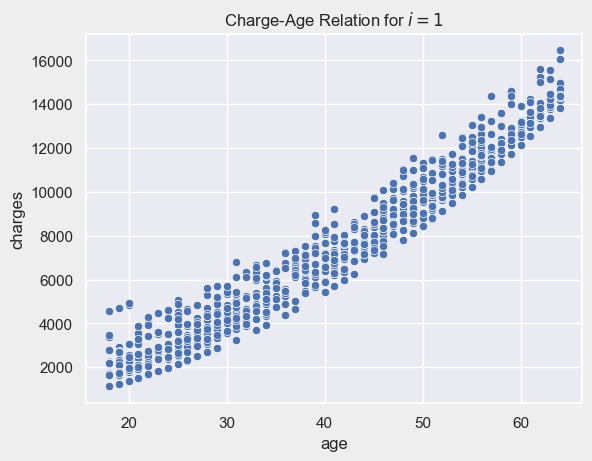

In [14]:
sns.scatterplot(data=df_low, x=Col.age, y=Col.charges)
plt.title('Charge-Age Relation for $i = 1$')
plt.show()

Now, we see that our assumption of a linear correlation here was wrong!  There is some arching
going on.  We can scale the axes to try and see if we can narrow down the nature of the
correlation:

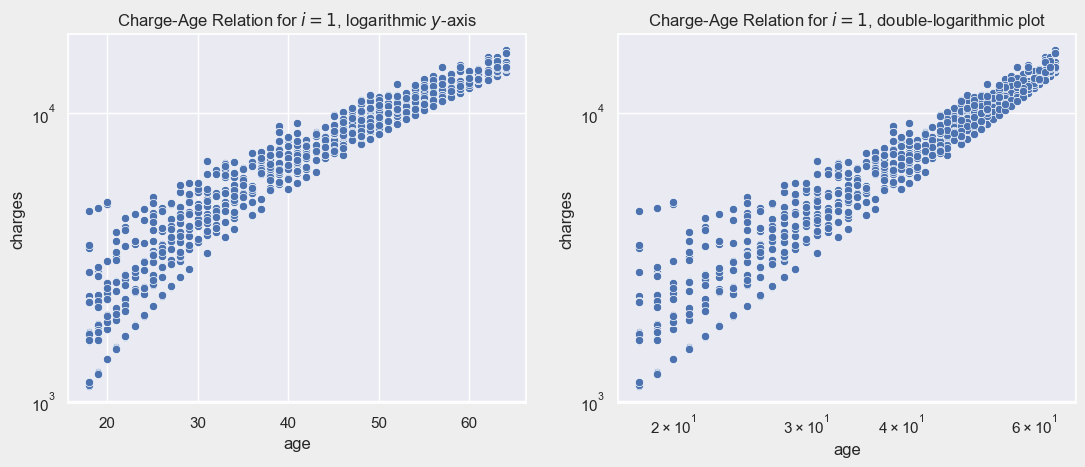

In [15]:
plt.figure(figsize=(13, 4.8))
plt.subplot(121)
sns.scatterplot(data=df_low, x=Col.age, y=Col.charges)
plt.yscale('log')
plt.title('Charge-Age Relation for $i=1$, logarithmic $y$-axis')
plt.subplot(122)
sns.scatterplot(data=df_low, x=Col.age, y=Col.charges)
plt.xscale('log')
plt.yscale('log')
plt.title('Charge-Age Relation for $i=1$, double-logarithmic plot')
plt.show()

The somewhat linear behavior in the double-logarithmic plot hints towards a polynomial
correlation.  And checking this quickly by assuming it to be 2nd degree and plotting
the charges over $a^2$ appears to confirm that:

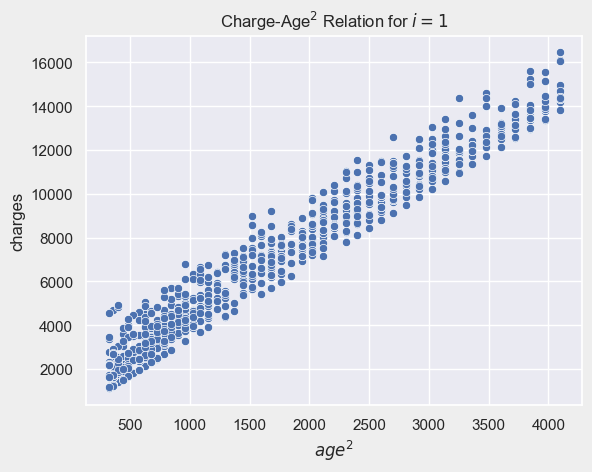

In [16]:
df_low[Col.age2] = df_low.age**2    # Col.age2 = '$age^2$'
sns.scatterplot(data=df_low, x=Col.age2, y=Col.charges)
plt.title('Charge-Age$^2$ Relation for $i=1$')
plt.show()

Thus, we can perform some quick and simple linear regression on this data to find
a (still somewhat naive) prediction of insurance charges per age.

We will do so by using and comparing three (slightly) different Python packages.
In order to avoid the notebook getting too big, we will split the three approaches
off here and return once we exercised them individually.

| Notebook                                                              | Package          |
| --------------------------------------------------------------------- | ---------------- |
| [SciKit-Learn approach](./age-charge-relation-sklearn.ipynb)          | `sklearn`        |
| [Statsmodel.API approach](./age-charge-relation-statsmodel-api.ipynb) | `statsmodel.api` |
| [ScyPy.Stats approach](./age-charge-relation-scipy-stats.ipynb)       | `scipy.stats`    |

In summary, all packages deliver essentially the same result, but they might need
some individual setup and/ or provide more or less insight into the statistics of
the result.  In terms of predictions, the `statsmodel.api` package has the most
convenient access to confidence niveous, as they can immediately called from
the regression result via the `.conf_int()` or the `conf_int_el()` methods.

As a quick recap, the three packages found the following parameters for our regression
attempt:

In [17]:
model = quick_regression(df_low[Col.age2], df_low[Col.charges])
print(f'Intercept:\t{model.intercept}')
print(f'Slope:\t\t{model.slope}')

Intercept:	1160.1072156361256
Slope:		3.3639813030572436


The confidence niveous differ a bit between `statsmodel.api` and their actual computation in
the `scipy.stats` notebook, but only by a negligible amount compared to the `costs` scale of
our data.  Thus, we will stick with the ones provided by `statsmodel.api`:

In [18]:
print(f'Intercept\tlower limit:\t{model.intercept_lower}')
print(f'Intercept\tupper limit:\t{model.intercept_upper}')
print(f'Slope\t\tlower limit:\t{model.slope_lower}')
print(f'Slope\t\tupper limit:\t{model.slope_upper}')

Intercept	lower limit:	1071.4021420650429
Intercept	upper limit:	1253.0234719199973
Slope		lower limit:	3.3208334601111686
Slope		upper limit:	3.4076569037110462


However, `sklearn` allows us to try something else with nigh-to-none extra effort
(which has not been showcased in the respective notebook):  One can perform polynomial
regression within the linear module by setting up the arguments a little bit differently,
and use its capabilities to process regressions of linear functions over multiple
independent arguments.  We will use this now to attempt to fit a quadratic formula
over the unscaled dataset, and compare it to the ones we have derived so far.

In [19]:
# Provide arguments in a slightly different way
x = pd.DataFrame(df_low.age)
x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)  # new x values
y = pd.DataFrame(df_low.charges)
model = LinearRegression().fit(x_, y)                                   # same base model
print(f'R^2:\t\t{model.score(x_, y)}\nIntercept:\t{model.intercept_[0]}\nCoefficients:\t{model.coef_[0]}')

R^2:		0.9618577716253013
Intercept:	-818.7194546260425
Coefficients:	[110.97949705   1.99568751]


Judging just by $R^2$, this approach *seems* to fit the data better.  However, plotting this
result (over the one we already arrived at) shows that the quadratic regression does *not*
capture the behavior of the data as good as our linear one!

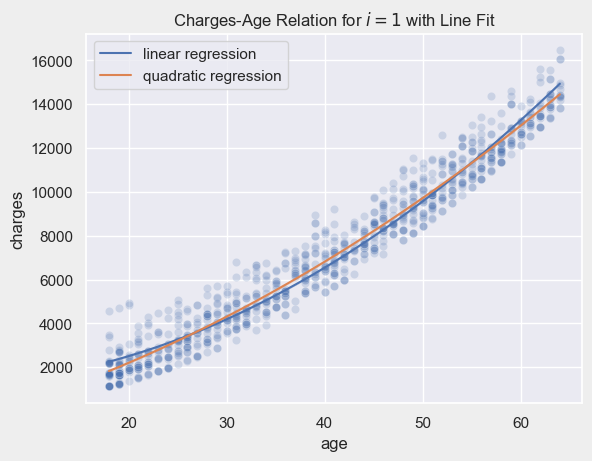

In [20]:
#df_low['line_pol'] = df_low.age.map(lambda age: model.intercept_[0] + age * model.coef_[0, 0] + age**2 * model.coef_[0, 1])
df_low['line_pol'] = model.predict(x_)

# Quickly reconstruct the regression from the previous attempt:
model = quick_regression(df_low[Col.age2], df_low[Col.charges])
df_low[Col.line] = model.predict(sm.add_constant(df_low[Col.age2])).flatten()

# Plot the results
sns.scatterplot(data=df_low, x=Col.age, y=Col.charges, alpha=.2)
sns.lineplot(data=df_low, x=Col.age, y=Col.line, label='linear regression')
sns.lineplot(data=df_low, x=Col.age, y='line_pol', label='quadratic regression')
plt.title('Charges-Age Relation for $i=1$ with Line Fit')
plt.show()

Thus, moving forward, we will stick with the former result.

Now, if we look back at the way we isolated the first level of our data, we can use a similar
approach to do the same with the other two.  However, this time we are in a better position:
we know that we are dealing with a three functions of the shape
$$c_{i, r}(a) = s \cdot a^2 + n_{i, r}$$
where $s$ is the slope we got from our earlier inspections.  And yes, we are assuming
it is the same for all three levels at this point.  $c_{i, r}(a)$ and $n_{i, r}$
take the same roles as in our linear assumption from earlier.
Now, instead of dividing by the age in order to 'linearize' the data points, we can subtract
the term $s \cdot a^2$ from the charges to get what
looks like data points oscillating around three different offsets:

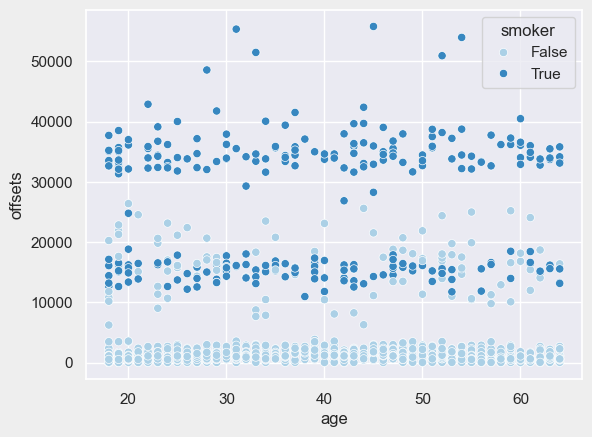

In [21]:
df[Col.offsets] = df.charges - model.slope * df.age**2
sns.scatterplot(data=df, x=Col.age, y=Col.offsets, hue=Col.smoker, palette=Palette.bl)
plt.show()

In an attempt to separate the levels, it would be nice to see if other factors play
into their contribution.  Thus, let us quickly look at these offsets with respect to
the only quantitative column we have aside from the `age` - the `bmi` - and also put
all the qualitative columns into consideration as well.

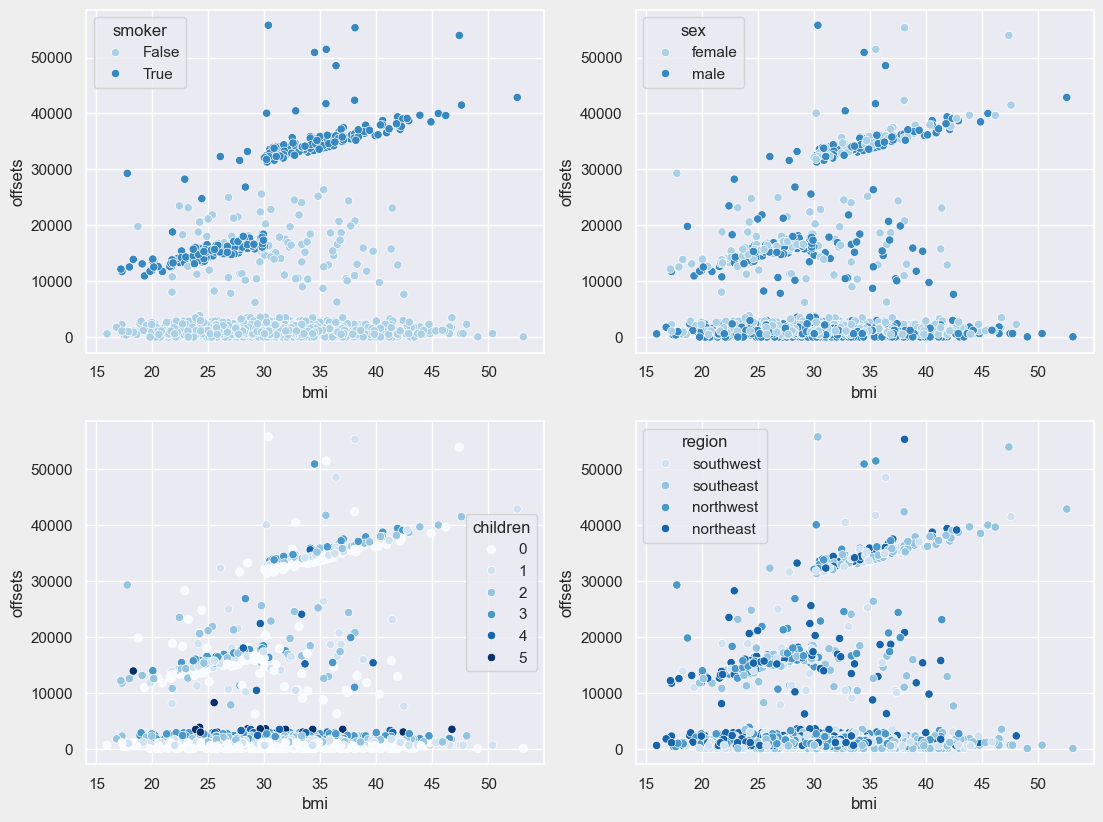

In [25]:
plt.figure(figsize=(13, 4.9*2))
plt.subplot(221)
sns.scatterplot(data=df, x=Col.bmi, y=Col.offsets, hue=Col.smoker, palette=Palette.bl)
plt.subplot(222)
sns.scatterplot(data=df, x=Col.bmi, y=Col.offsets, hue=Col.sex, palette=Palette.bl)
plt.subplot(223)
sns.scatterplot(data=df, x=Col.bmi, y=Col.offsets, hue=Col.children, palette=Palette.bl)
plt.subplot(224)
sns.scatterplot(data=df, x=Col.bmi, y=Col.offsets, hue=Col.region, palette=Palette.bl)
plt.show()

The top left graph shows that there is a clear BMI limit at which the offset jumps,
and that this goes for smokers exclusively.  On top of that, it
indicates that there is basically a linear correlation between the offset
of the smoker charges and the person's BMI.  Non-smokers do not get such a penalty,
again.

And a look at the lower left graph raises the suspicion that the number of children,
too, raises the offset. The general tendency, ignoring outliers, seems to be that each
child adds a little penalty.

To make those observations a bit more clear, let us remove the non-smokers from the plots:

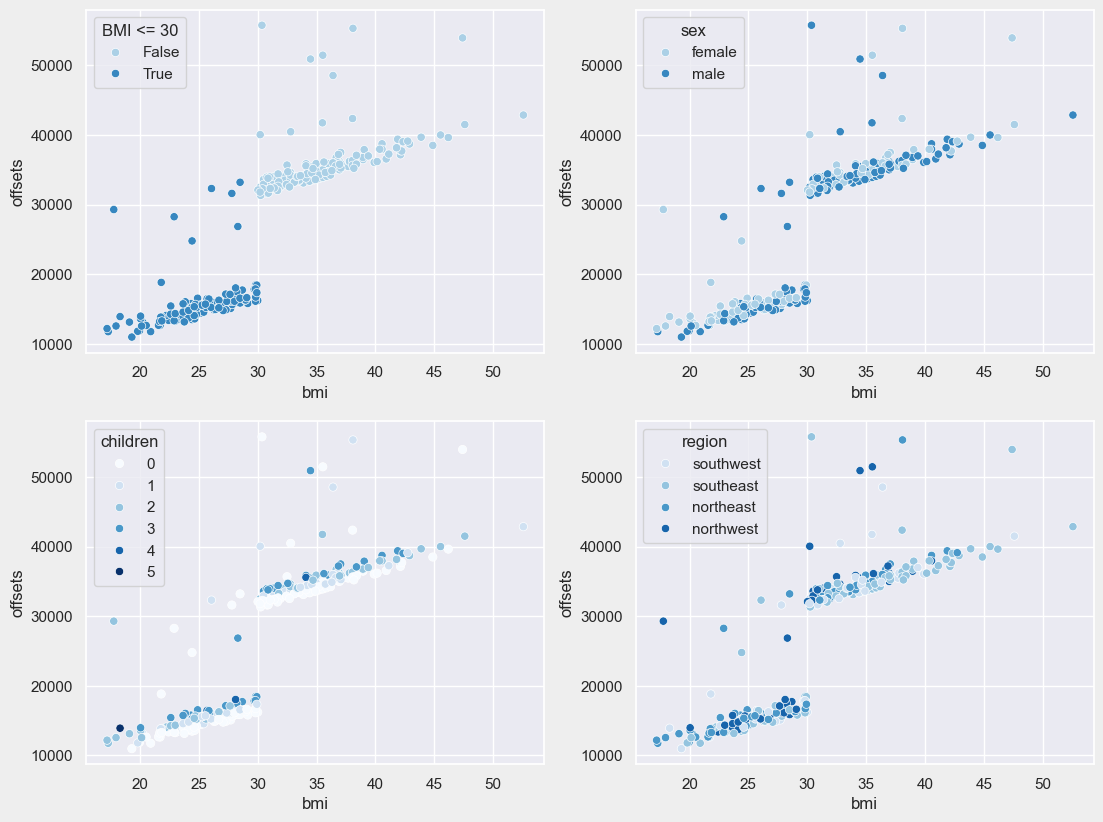

In [23]:
bmi_df = pd.DataFrame(df[df.smoker])
bmi_df[Col.bmi30] = bmi_df.bmi.map(lambda bmi: bmi <= 30)   # Col.bmi30 = 'BMI <= 30'

plt.figure(figsize=(13, 4.9*2))
plt.subplot(221)
sns.scatterplot(data=bmi_df, x=Col.bmi, y=Col.offsets, hue=Col.bmi30, palette=Palette.bl)
plt.subplot(222)
sns.scatterplot(data=df[df.smoker], x=Col.bmi, y=Col.offsets, hue=Col.sex, palette=Palette.bl)
plt.subplot(223)
sns.scatterplot(data=df[df.smoker], x=Col.bmi, y=Col.offsets, hue=Col.children, palette=Palette.bl)
plt.subplot(224)
sns.scatterplot(data=df[df.smoker], x=Col.bmi, y=Col.offsets, hue=Col.region, palette=Palette.bl)
plt.show()

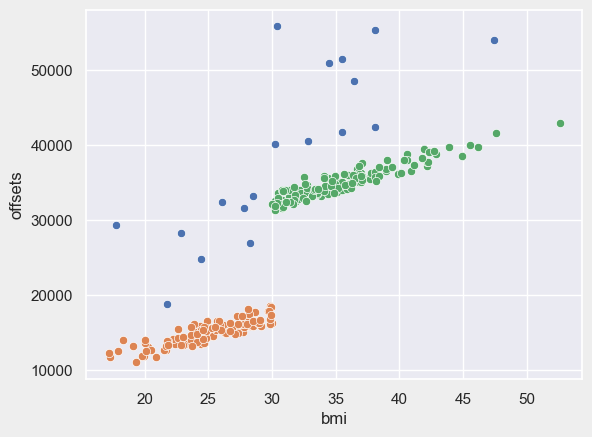

In [30]:
# Split bmi_df into smaller DataFrame objects
bmi_df_lower = bmi_df[bmi_df[Col.bmi30]].copy()
bmi_df_upper = bmi_df[~bmi_df[Col.bmi30]].copy()

# Apply the filter masks to remove outliers; assumption for upper: slope gonna be around roughly 500
bmi_df_lower_filtered = bmi_df_lower[bmi_df_lower[Col.offsets] < 18.7e3].copy()
bmi_df_upper_filtered = bmi_df_upper[bmi_df_upper.eval('offsets < 5e2 * (bmi - 30) + 37e3')].copy()

# Plot to verify successful extraction
sns.scatterplot(data=bmi_df, x=Col.bmi, y=Col.offsets)
sns.scatterplot(data=bmi_df_lower_filtered, x=Col.bmi, y=Col.offsets)
sns.scatterplot(data=bmi_df_upper_filtered, x=Col.bmi, y=Col.offsets)
plt.show()

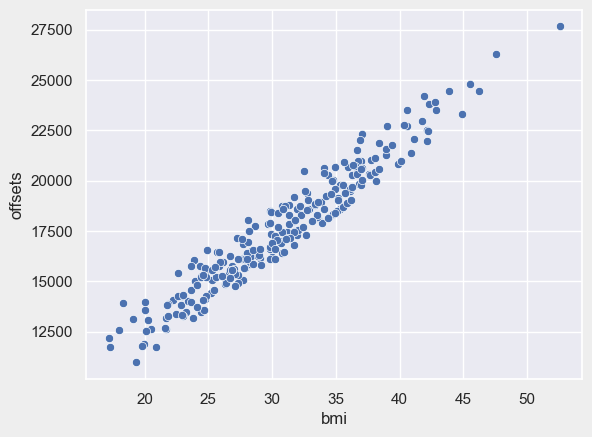

In [31]:
# Join filtered datasets such that lowest childless offset around BMI 30 match up
step = bmi_df_upper_filtered[bmi_df_upper_filtered.bmi < 30.5].offsets.min() - \
    bmi_df_lower_filtered[bmi_df_lower_filtered.bmi > 29.5].offsets.min()

bmi_df_upper_filtered_shifted = bmi_df_upper_filtered.copy()
bmi_df_upper_filtered_shifted.offsets -= step

bmi_df_filtered_joined = pd.concat([bmi_df_lower_filtered, bmi_df_upper_filtered_shifted], axis=0)

sns.scatterplot(data=bmi_df_filtered_joined, x=Col.bmi, y=Col.offsets)
plt.show()

In [32]:
# Linear Regression
x  = bmi_df_filtered_joined.bmi
x_ = sm.add_constant(x)
y  = bmi_df_filtered_joined.offsets

model = sm.OLS(y, x_).fit()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                offsets   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     3598.
Date:                Wed, 15 May 2024   Prob (F-statistic):          5.65e-152
Time:                        14:57:19   Log-Likelihood:                -2062.0
No. Observations:                 256   AIC:                             4128.
Df Residuals:                     254   BIC:                             4135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3484.8257    239.247     14.566      0.000    3013.666    3955.986
bmi          458.0882      7.637     59.980      0.000     443.047     473.129
==============================================================================
Omnibus:                       12.870   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.032
Skew:                           0.430   Prob(JB):                      0.00402
Kurtosis:                       2.457   Cond. No.                         157.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Add the prediction data to the data frames
bmi_df_lower_filtered[Col.line] = model.predict(sm.add_constant(bmi_df_lower_filtered.bmi))
bmi_df_upper_filtered[Col.line] = model.predict(sm.add_constant(bmi_df_upper_filtered.bmi)) + step

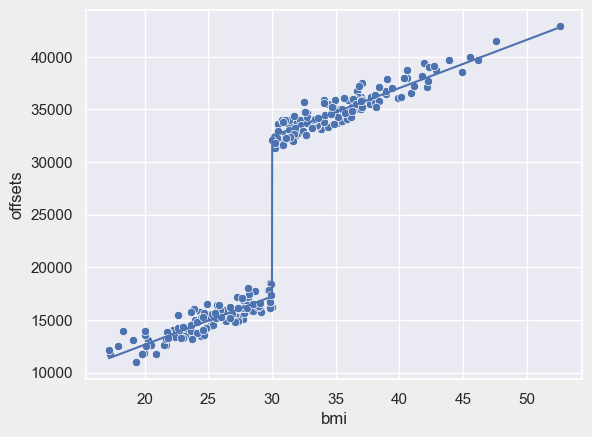

In [35]:
# Plot the data
bmi_df_filtered_fitted_joined = pd.concat([bmi_df_lower_filtered, bmi_df_upper_filtered])
sns.scatterplot(data=bmi_df_filtered_fitted_joined, x=Col.bmi, y='offsets')
sns.lineplot(data=bmi_df_filtered_fitted_joined, x=Col.bmi, y='line')
plt.show()

--------------------

Back to the [README](./README.md)

To the [next notebook](./sex-charge-relation.ipynb)